# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import gpt

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
bs=32
bptt=400

In [4]:
# PATH=Path('data/wikitext-2-raw')
PATH = Path('data/composers/notewise/piano_solo/note_range62/sample_freq12')
data = TextLMDataBunch.load(PATH, bs=bs, bptt=bptt)

In [5]:
vocab = data.train_ds.vocab
vocab_size = len(vocab.itos); vocab_size

158

In [6]:
t = data.train_ds[0][0]
t.text[:50], t.data

('xxbos wait25 wait25 wait25 wait25 wait25 wait25 wa',
 array([  2, 124, 124, 124, ...,   9, 105,   9, 157]))

In [7]:
# data.show_batch()

## Sanity - make sure outputs match

In [8]:
# learn = language_model_learner(data, drop_mult=1, clip=.5, bptt=250)

# ob = data.one_batch()

# out = learn.model(ob[0].cuda())

# out[0].shape

# len(out[1])

### Transformer Arch
Paper: https://arxiv.org/abs/1706.03762  
Inspiration: https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [7]:
config = gpt.OpenAIGPTConfig(vocab_size)
# config = bert.BertConfig(vocab_size)

In [8]:
config.n_embd = int(config.n_embd/2)
config.n_layer = int(config.n_layer/2)
config.n_head = int(config.n_head/2)

In [9]:
config

{
  "afn": "gelu",
  "attn_pdrop": 0.1,
  "embd_pdrop": 0.1,
  "initializer_range": 0.02,
  "n_ctx": 512,
  "n_embd": 384,
  "n_head": 6,
  "n_layer": 6,
  "n_special": 0,
  "resid_pdrop": 0.1,
  "vocab_size": 158
}

In [10]:
# model = bert.BertForPreTraining(config).cuda()
model = gpt.OpenAIGPTLMHeadModel(config).cuda()
model.reset = lambda: None

In [11]:
# model

In [12]:
# ob = data.one_batch(); ob[0].shape

# out = model(ob[0].cuda())

# len(out)

# out[1].shape

# out[0].shape

### Create Language learner

In [13]:
learn = LanguageLearner(data, model, bptt, clip=1)

In [14]:
learn.callbacks = []

In [17]:
# learn = learn.to_fp16(32)

In [18]:
# learn.lr_find()

In [19]:
# learn.recorder.plot()

## Must remeber that BERT is bidirectional, so we must modifythe architechture so it won't cheat

In [20]:
learn.fit_one_cycle(4, 1e-4, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.800304,1.648704,0.533358
2,1.302375,1.247379,0.649127
3,1.336538,1.149710,0.671989
4,1.301050,1.116538,0.680818


In [21]:
learn.save('gpt_first_run_save')

In [24]:
learn.fit_one_cycle(4, 1e-4, div_factor=5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.244033,1.136642,0.677783
2,1.135503,1.079520,0.693552
3,1.012233,1.025614,0.707242
4,1.013113,1.000321,0.713043


In [25]:
learn.save('gpt_second_run_save')

In [ ]:
learn.fit_one_cycle(10, 1e-5, div_factor=5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy


In [28]:
learn.save('gpt_third_run_save')

In [15]:
learn = learn.load('gpt_third_run_save')

In [17]:
learn.fit_one_cycle(1, 1e-4, div_factor=5, moms=(0.7,0.5))

epoch,train_loss,valid_loss,accuracy
1,1.031490,0.986020,0.717154


In [19]:
learn.save('gpt_fourth_run_save')

In [21]:
learn.show_results()

text,target,pred
xxbos p28 p44 p47 wait3 p52 wait4 endp47 wait1 endp28 endp44 endp52 wait4 p23 p52 wait2 endp52 wait1 p51 wait2,wait1 p49 wait2 endp23 endp49 wait1 p47 wait2 endp47 wait1 p28 p52 wait5 endp28 endp52 wait1 p23 p47 wait5 endp23,wait1 p52 wait2 endp49 endp49 wait1 p47 wait2 endp47 wait1 p45 p44 wait2 endp28 endp52 wait1 p27 p51 wait5 endp23
endp27 wait1 endp30 wait1 p31 wait2 endp31 wait1 p25 wait1 p34 wait1 endp8 endp20 endp25 wait1 p10 p22 endp34 p37,p28 endp37 wait1 p32 wait1 endp28 wait1 endp32 wait1 p33 wait2 endp33 wait1 p27 wait1 p39 wait1 endp10 endp22 endp27,endp37 endp37 wait1 p31 wait1 endp28 wait1 endp10 wait1 p25 wait2 endp33 wait1 p28 wait1 p30 wait1 endp10 endp22 endp27
wait1 p7 p31 p36 wait3 endp31 endp36 wait3 p34 p38 wait3 endp34 endp38 wait6 p39 wait2 endp39 wait1 p36 p43,endp36 endp43 wait3 p34 p38 wait3 endp34 endp38 wait6 p31 wait2 endp31 wait1 p7 p26 p34 wait3 endp26 endp34 wait2,endp36 endp43 wait6 p34 p38 wait3 endp34 endp38 wait3 p39 p34 endp31 wait1 endp7 p19 wait3 wait3 endp26 endp34 wait3
endp29 endp34 wait4 endp13 endp20 wait3 p19 p23 p27 p30 p35 wait2 p12 wait5 endp23 wait1 endp30 wait3 endp27 endp35,endp19 wait2 p21 p26 p28 p31 p33 wait4 endp12 wait4 endp21 endp26 endp28 endp31 wait3 endp33 wait4 p15 p27 p30,endp19 wait1 endp12 p27 p30 p31 p33 wait2 endp12 wait1 endp21 endp26 endp28 endp31 endp33 endp33 wait1 p11 p21 p31
p21 p45 wait5 endp45 wait1 p38 wait6 p9 wait5 endp38 wait1 p37 wait5 endp9 endp21 endp37 wait1 p14 p38 wait2,wait1 p37 wait2 endp37 wait1 p35 wait2 endp35 wait1 p33 wait2 endp14 endp33 wait1 p19 p31 wait1 p30 wait1 endp31,wait1 p40 wait2 endp37 wait1 p38 wait2 endp35 wait1 p33 wait2 endp14 endp33 wait1 p16 p35 wait2 p33 wait1 endp31


In [53]:
path = PATH
idx = 4
folder_idx = 2 # 2 = bach
seed_len = 200

file = path.ls()[folder_idx].ls()[idx]
with open(file, 'r') as f:
    txt_out = f.read()
notes = txt_out.split(' ')
seed = ' '.join(notes[:seed_len])

note_offset = 45 if 'note_range38' in str(file) else 33
sample_freq = 12 if 'sample_freq12' in str(file) else 4

note_offset, sample_freq, file

(33,
 12,
 PosixPath('data/composers/notewise/piano_solo/note_range62/sample_freq12/bach/bwv872.txt'))

In [54]:
pred_out = learn.predict(seed, n_words=200)

In [55]:
pred_only = pred_out.replace(seed, '').strip(); pred_only

'p26 p41 wait5 endp41 wait1 p39 wait5 endp39 wait1 p38 wait5 endp38 wait1 p34 p41 wait5 endp41 wait1 p38 wait5 endp26 endp34 endp38 endp46 wait1 p22 p32 wait6 p38 wait5 endp38 wait1 p32 p41 wait5 endp41 wait1 p46 wait5 endp22 wait1 p32 p41 wait5 endp41 wait1 p38 wait5 endp32 endp38 endp46 wait1 p15 p31 wait6 p38 wait5 endp38 wait1 p31 p39 wait5 endp39 wait1 p43 wait5 endp15 endp31 wait1 p39 p43 wait5 endp43 wait1 p39 wait5 endp39 wait1 p43 p46 wait5 endp43 wait1 p39 wait5 endp39 wait1 p31 p34 wait5 endp31 endp34 wait1 p39 p43 wait5 endp39 endp43 wait1 p27 p51 wait5 endp51 wait1 p43 wait5 endp27 endp43 endp46 wait1 p24 p32 wait6 p39 wait5 endp39 wait1 p32 p41 wait5 endp41 wait1 p48 wait5 endp24 endp32 wait1 p36 p41 wait5 endp41 wait1 p39 wait5 endp36 endp39 endp48 wait1 p23 p31 wait6 p40 wait5 endp40 wait1 p31 p41 wait5 endp41 wait1 p47 wait5 endp23 endp31 wait1 p35 p41 wait5 endp41 wait1 p43 wait5 endp35 endp43 endp47 wait1 p21 p34 wait6 p41 wait5 endp41 wait1 p34 p39 wait5 endp39 wait

In [56]:
from utils import *
import music21
from music21 import *
from IPython.display import Image, Audio

In [57]:
pred_format = pred_out.replace('xxbos ', '')

In [58]:
note_stream = arrToStreamNotewise(pred_format.split(' '), sample_freq=sample_freq/2, note_offset=45)

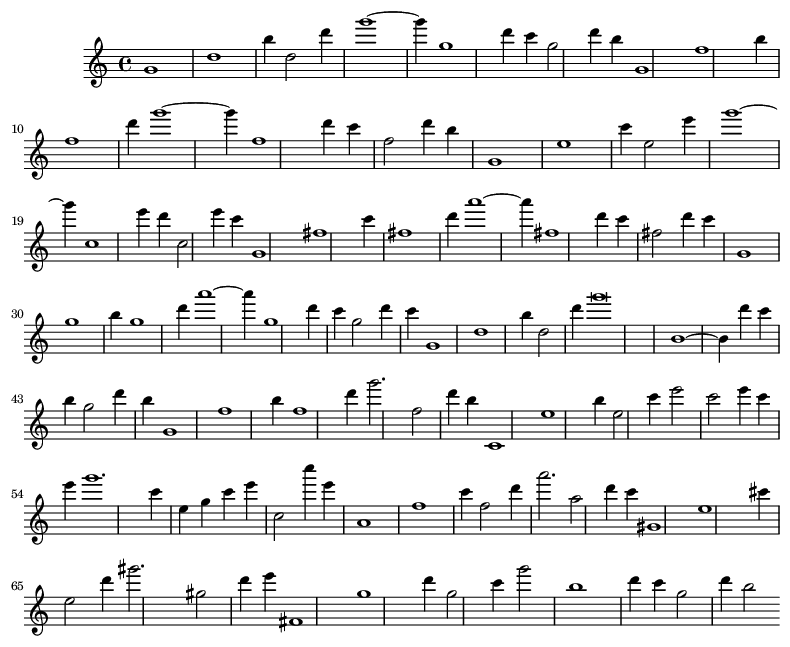

In [59]:
Image(filename=str(note_stream.write('lily.png')))

In [60]:
note_stream.show('midi')

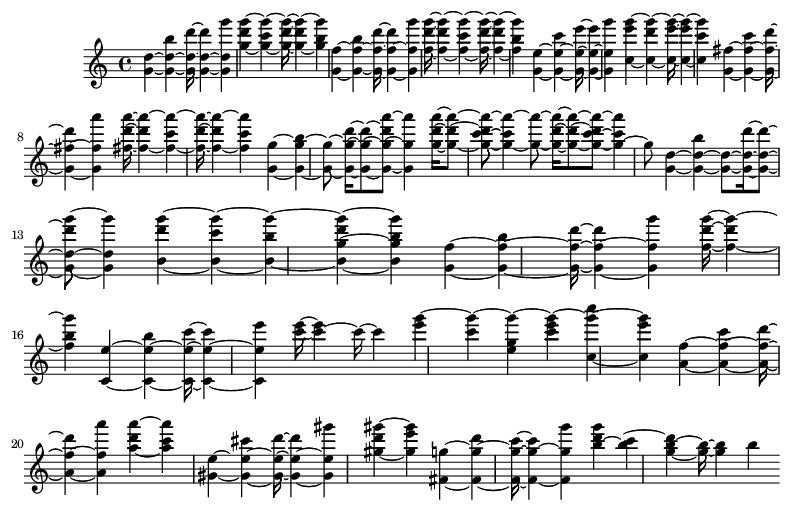

In [61]:
Image(filename=str(note_stream.chordify().write('lily.png')))